In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from src.model import Net
from src.interpolate import interpolate
import src.data_manager as data_manager
from src.dataset import pil_to_numpy
from skimage.measure import compare_nrmse, compare_psnr, compare_ssim
import ntpath
import random

from collections import defaultdict

In [3]:
!pwd

/home/ketanagrawal/sepconv


In [ ]:
# Plot loss graphs for L1 and L1 + VGG Loss

train_loss, val_loss = pickle.load(open('/home/ketanagrawal/cs231n-fp/loss.p', 'rb'))
print(train_loss)

val_l1_loss = [v[0] for v in val_loss]
print(val_l1_loss)

In [35]:
# Plot loss graphs for L1 and L1 + VGG Loss

train_lf_loss, val_lf_loss = pickle.load(open('/home/ketanagrawal/cs231n-fp/loss_lf.p', 'rb'))
print(train_loss)

val_l1vgg_loss = [v[0] for v in val_lf_loss]
print(val_l1vgg_loss)

[0.3380206525325775, 0.24883026132980982, 0.13796441412220398, 0.09679069576991929, 0.07669181982055306, 0.08121254662465718, 0.08697584675004084, 0.07235567333797614, 0.07870844306631221, 0.0682143687736243]
[0.4783192733923594, 0.19187869479258854, 0.17797935009002686, 0.10936970760424931, 0.17752036303281785, 0.17203022688627242, 0.17132379710674286, 0.11326648518443108, 0.16180635939041774, 0.11125090544422468]


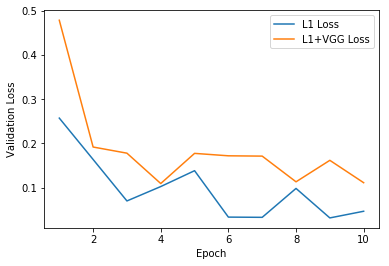

In [38]:
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.plot(np.arange(10) + 1, val_l1_loss, label='L1 Loss')
plt.plot(np.arange(10) + 1, val_l1vgg_loss, label='L1+VGG Loss')
plt.legend()
plt.show()

In [4]:
test_tuples = pickle.load(open('/home/ketanagrawal/cs231n-fp/test_tuples.p', 'rb'))
print(len(test_tuples))

4950


In [7]:
models = {}

for model_type in ['l1', 'l1color', 'lf']:
    models[model_type] = Net.from_file('/home/ketanagrawal/sepconv/out_{}/model_epoch_10.pth'.format(model_type))

In [40]:
models['baseline'] = Net.from_file('/home/ketanagrawal/sepconv/out_l1/model_epoch_1.pth')

In [29]:
models['lf_new'] = Net.from_file('/home/ketanagrawal/sepconv/out_l1/model_epoch_latest.pth')

In [41]:
ssims = defaultdict(list)
psnrs = defaultdict(list)
rmses = defaultdict(list)
interp_paths = []

for i, tup in enumerate(test_tuples[::-1]):
    if i % 100 == 0:
        print(i)
    fname = ntpath.basename(tup[1])
    tup = [data_manager.load_img(x) for x in tup]

    for model_type in ['baseline']:
        output = interpolate(models[model_type], tup[0], tup[2])
        np.save('/home/ketanagrawal/cs231n-fp/interpolated/interp_{}_{}'.format(model_type, fname), output)
        tup[1] = pil_to_numpy(tup[1]).reshape(100, 100, -1)
        output = pil_to_numpy(output).reshape(100, 100, -1)
        
        ssims[model_type].append(compare_ssim(output, tup[1], win_size=11, multichannel=True))
        psnrs[model_type].append(compare_psnr(tup[1], output))
        rmses[model_type].append(compare_nrmse(tup[1], output))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [42]:
#Get average SSIM, PSNR, RMSE values.

for model_type in ['baseline']:
    print('{}: '.format(model_type))
    print('SSIM: {}'.format(np.average(ssims[model_type])))
    print('PSNR: {}'.format(np.average(psnrs[model_type])))
    print('NRMSE: {}'.format(np.average(rmses[model_type])))


baseline: 
SSIM: 0.9707738434722744
PSNR: 24.43852654441958
NRMSE: 0.1050149348051823


In [58]:
def plot_true_interp():
    num_samples = 8
    samples = random.sample(test_tuples, num_samples)
    cols = 2
    fig, ax = plt.subplots(num_samples, cols, figsize=(15*cols, 15*num_samples))
    y = 0
    for i in range(num_samples):
        before_fp = samples[i][0]
        true_fp = samples[i][1]
        after_fp = samples[i][2]
        print(ntpath.basename(true_fp))
        
        interp_fp = '/home/ketanagrawal/cs231n-fp/interpolated/interp_{0}_{1}'.format('l1', ntpath.basename(true_fp))
        interp_b_fp = '/home/ketanagrawal/cs231n-fp/interpolated/interp_{0}_{1}'.format('baseline', ntpath.basename(true_fp))
#         if not os.path.exists(interp_fp):
#             print('{} doesn\'t exist'.format(interp_fp))
#             continue
            
#         before = np.load(before_fp)
#         ax[y, 0].imshow(before)
#         ax[y, 0].set_title('Before')
        
#         after = np.load(after_fp)
#         ax[y, 1].imshow(after)
#         ax[y, 1].set_title('After')
        
        interp = np.load(interp_fp)
#         print(interp)
        ax[y, 0].imshow(interp)
        ax[y, 0].set_title('{} Model'.format('l1'))
        
        interp_b = np.load(interp_b_fp)
#         print(interp_b)
        ax[y, 1].imshow(interp_b)
        ax[y, 1].set_title('{} Model'.format('lf'))
        
#         true = np.load(true_fp)
#         ax[y, 4].imshow(true)
#         ax[y, 4].set_title('True')
        y += 1
    plt.show()

In [55]:
def plot_single_true_interp(path):
#     num_samples = 4
#     samples = random.sample(test_tuples, num_samples)
    nrows, ncols = 2, 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(15*ncols, 15*nrows))
    y = 0

    true_fp = path
    split = ntpath.basename(true_fp).split('_')
    ts, rest = int(split[0]), '_'.join(split[1:])
    print(ts)
    print(rest)

    print(ntpath.basename(true_fp))
    
    start = 1490918688000
    end = 1491238734000
    interval = int((end - start)/200)
    before_fp = '/home/ketanagrawal/cs231n-fp/test/{0}_{1}'.format(ts - interval, rest)
    after_fp = '/home/ketanagrawal/cs231n-fp/test/{0}_{1}'.format(ts + interval, rest)

    interp_fp = '/home/ketanagrawal/cs231n-fp/interpolated/interp_{0}_{1}'.format('l1', ntpath.basename(true_fp))
    interp_b_fp = '/home/ketanagrawal/cs231n-fp/interpolated/interp_{0}_{1}'.format('baseline', ntpath.basename(true_fp))

    before = np.load(before_fp)
    ax[0, 0].imshow(before)
    ax[0, 0].set_title('Before', fontdict={'fontsize': 30})

    after = np.load(after_fp)
    ax[0, 2].imshow(after)
    ax[0, 2].set_title('After', fontdict={'fontsize': 30})

    interp = np.load(interp_fp)
#         print(interp)
    ax[1, 0].imshow(interp)
    ax[1, 0].set_title('Interpolated {}'.format('l1'), fontdict={'fontsize': 30})
    
    interp_b = np.load(interp_b_fp)
#         print(interp)
    ax[1, 2].imshow(interp_b)
    ax[1, 2].set_title('Interpolated {}'.format('lf'), fontdict={'fontsize': 30})

#     interp_b = np.load(interp_b_fp)
# #         print(interp_b)
#     ax[2, 1].imshow(interp_b)
#     ax[2, 1].set_title('{} Model'.format('baseline'))

    true = np.load(true_fp)
    ax[1, 1].imshow(true)
    ax[1, 1].set_title('True Middle', fontdict={'fontsize': 30})
    y += 1
    plt.show()

1490982697200
at_500_600_500_600.npy
1490982697200_at_500_600_500_600.npy


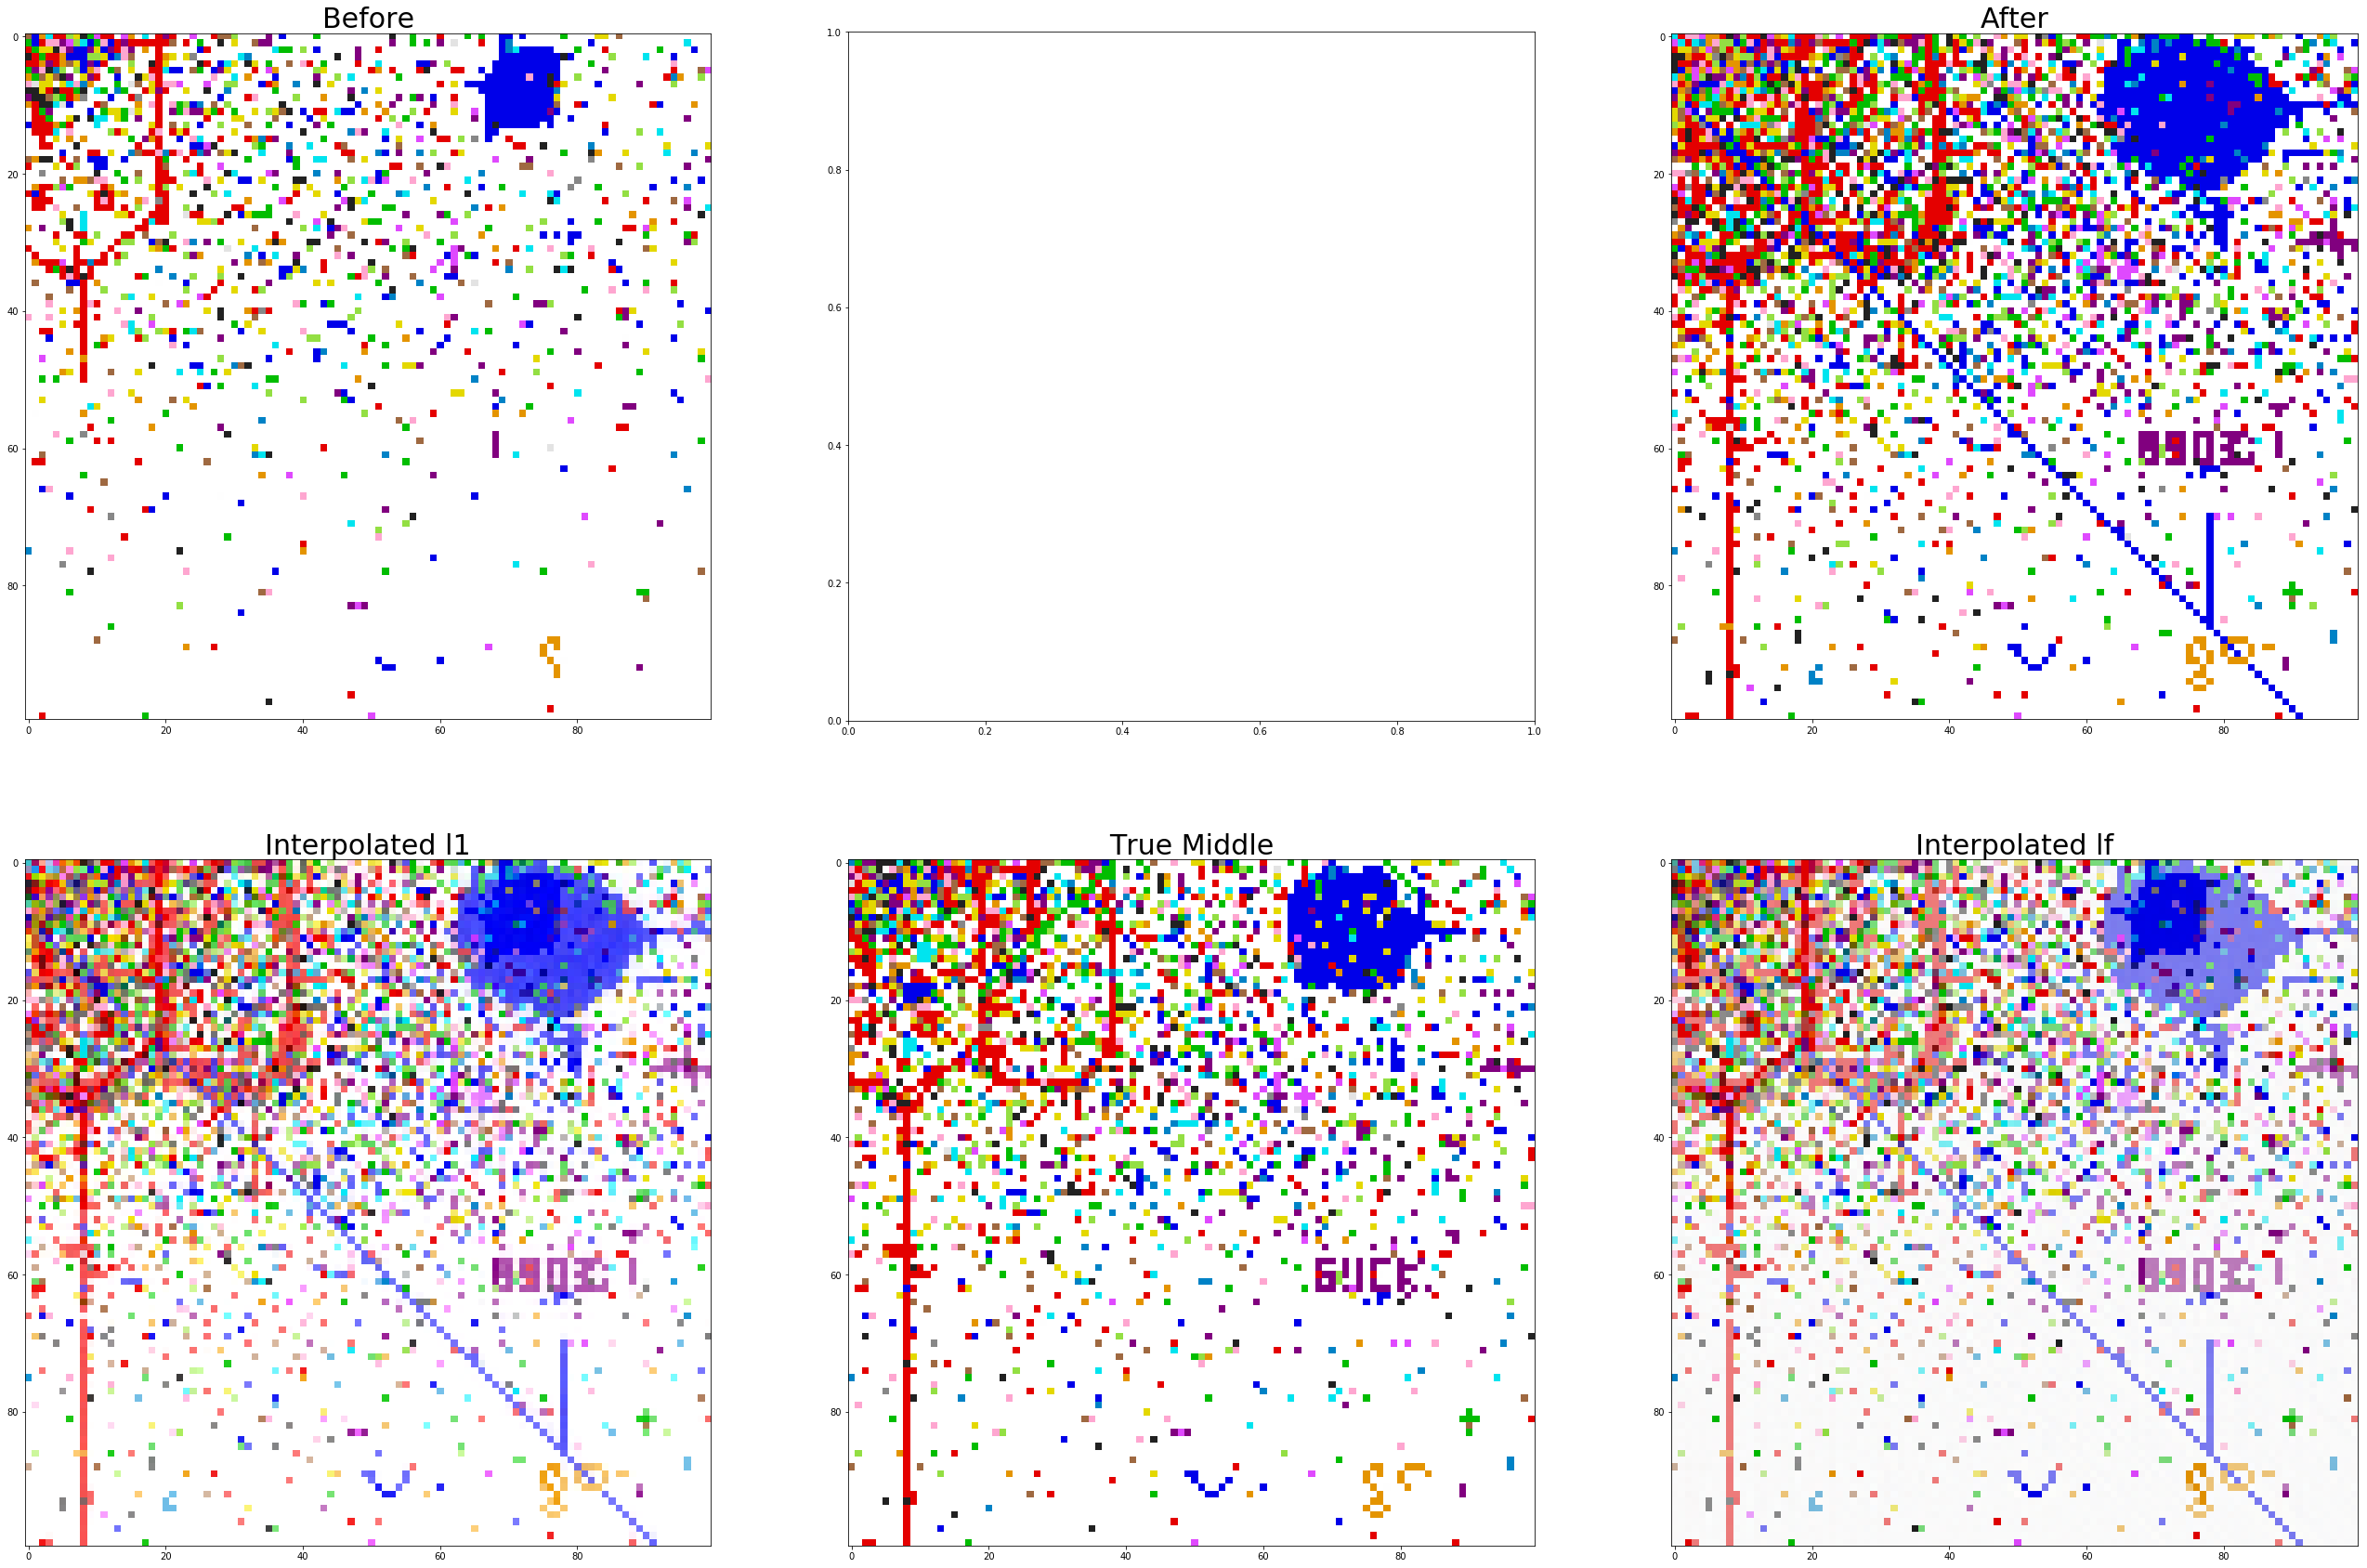

In [60]:
plot_single_true_interp('/home/ketanagrawal/cs231n-fp/test/1490982697200_at_500_600_500_600.npy')

1491233933310_at_500_600_800_900.npy
1490973095820_at_700_800_100_200.npy
1491176325030_at_700_800_400_500.npy
1491089912610_at_200_300_800_900.npy
1491235533540_at_500_600_500_600.npy
1490947492140_at_600_700_600_700.npy
1491225932160_at_0_100_700_800.npy
1491176325030_at_500_600_600_700.npy


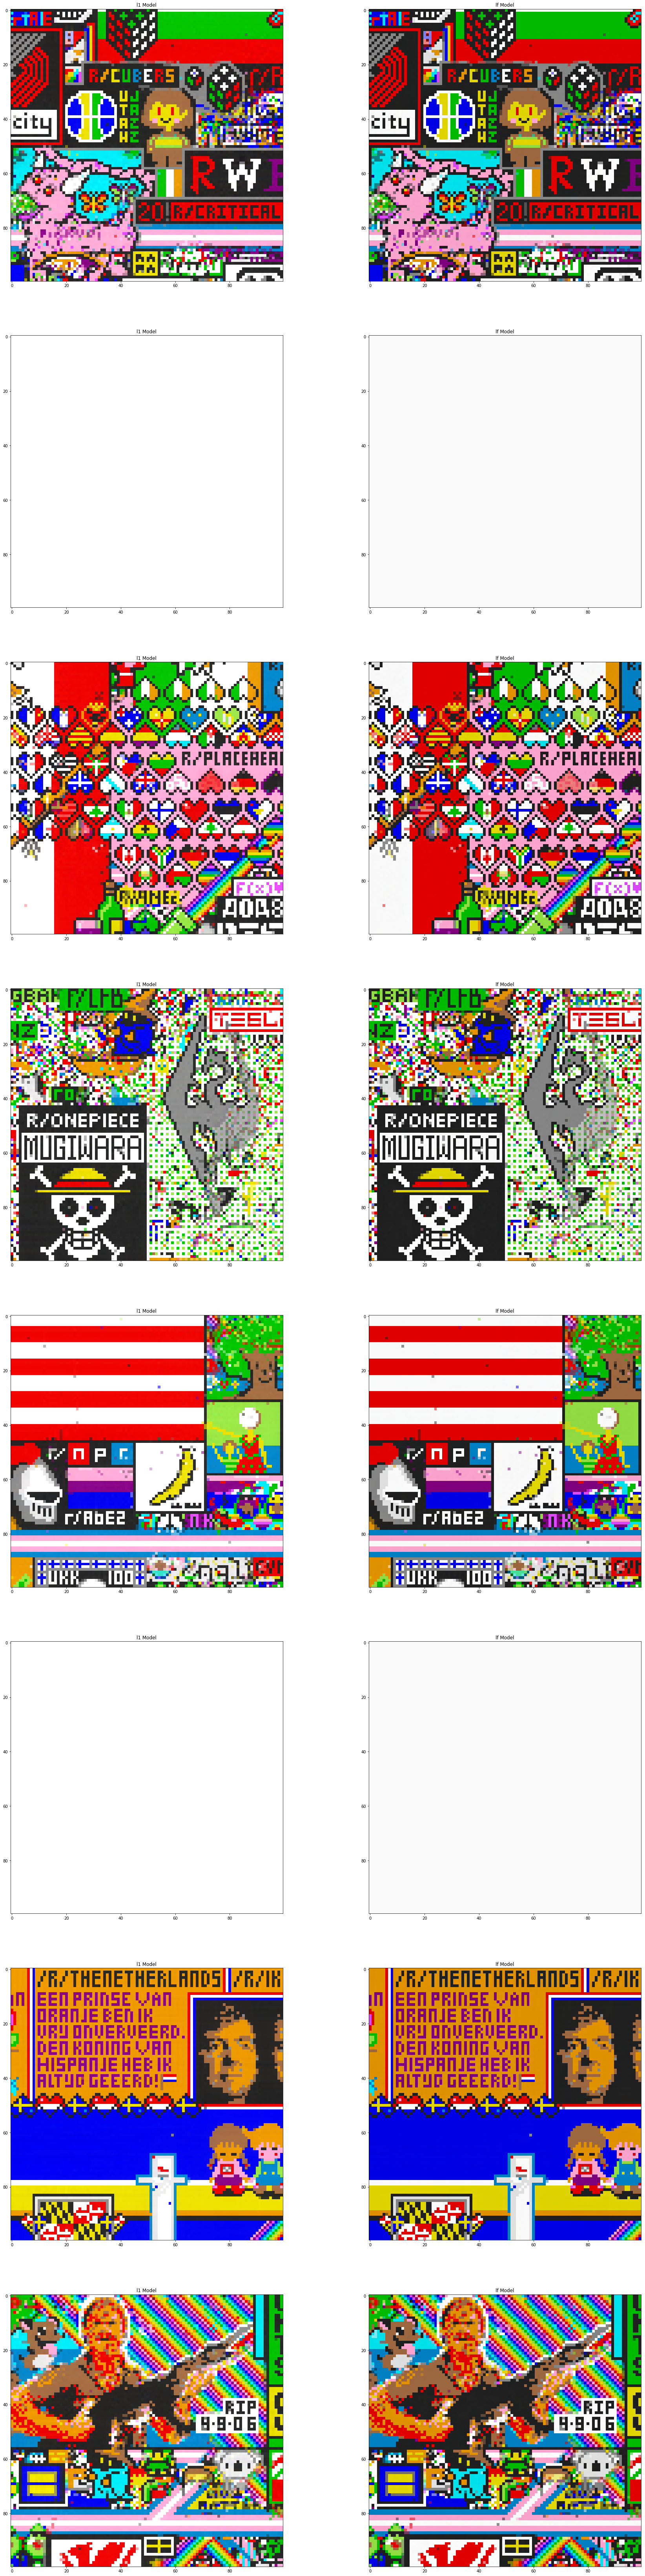

In [61]:
plot_true_interp()

In [ ]:
"""
Interesting ones:
good:
1491013101570_at_100_200_500_600.npy

bad:
1491209929860_at_200_300_500_600.npy (TWICE, HYGGE)
1490979496740_at_900_1000_300_400.npy

Limitations
Sometimes it finds the intermediate frame, but often it sticks w/ the first or the last frame (velocity problem.)
16 colors thing.

"""